# INTRODUCTION

## Statement of the problem

Portfolio optimization is the process of selecting the best portfolio (asset distribution), out of the set of all portfolios being considered, according to some objective. The objective typically maximizes factors such as expected return, and minimizes costs like financial risk through a correct diversification. The usual way to test this optimal portfolio is to compare its perfomance against a well known stock index, using it as a benchmark for the possible returns. A stock index, or stock market index, is an index that measures a stock market, or a subset of the stock market, that helps investors compare current price levels with past prices to calculate market performance. It is computed from the prices of selected stocks (typically a weighted arithmetic mean).

The Dow Jones Industrial Average (DJIA), or simply Dow Jones, is a stock market index that measures the stock performance of 30 large companies listed on stock exchanges in the United States. This is by far the most followed index in US stock markets. The value of the index is the sum of the price of one share of stock for each component company divided by a factor which changes whenever one of the component stocks has a stock split or stock dividend, so as to generate a consistent value for the index. The Industrial portion of the name is largely historical, as many of the modern 30 components have little or nothing to do with traditional heavy industry. The index is maintained by S&P Dow Jones Indices, a joint venture majority-owned by S&P Global and its components are selected by a committee.

In this work, inspired by the *Machine Learning and Reinforcement Learning in Finance Specialization* of *Coursera*, we are going to study a proposal for portfolio optimization based on the construction of eigen-portfolios using Principal Component Analysis (PCA) \[1\]. This will provide a model-free factor analysis, in the sense that we do not rely on any factors such as value or momentum to decompose portfolio returns, but instead using PCA to deduce structure of portfolio returns.

## References

\[1\] Marco Avellaneda & Jeong-Hyun Lee (2010) *Statistical arbitrage in the US equities market*, Quantitative Finance, 10(7), 761-782, DOI: [10.1080/14697680903124632](https://doi.org/10.1080/14697680903124632)

\[2\] William F. Sharpe (1966) *Mutual Fund Performance*, Journal of Business, 39(1), 119–138, DOI: [10.1086/294846](https://www.jstor.org/stable/2351741).

# DATA

## Libraries

In [366]:
# Basics
import pandas as pd
import numpy as np
import random

# Domain specific
import pandas_datareader as pdr
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.decomposition import PCA

## Importing data

We are going to construct our portfolio taking into account the stocks contained into DJI index, this will allow su to compare the performance of our eigen-portfolios with the performance of DJI index, which is one of the most followed indicators of the market state. So, the first step in our project is to obtain the data of the daily prices of these stocks. We can obtain this data from Yahoo Finance for example:

In [367]:
# Select the 30 stocks of DJI plus the DJI itself
stocks =  ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DOW', 'XOM', 
           'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 
           'PFE', 'PG', 'RTX', 'TRV', 'UNH', 'VZ', 'V', 'WMT', 'WBA', 'DIS', '^DJI']

# Select the dates 
date_start = datetime(2000, 1, 1)
date_end   = datetime(2018, 12, 31)

# Import data from Yahoo Finance
df = pdr.get_data_yahoo(symbols = stocks, start = date_start, end = date_end)

# Keep only closing prices
df = df[['Close']]

# Delete annoying labels
df.columns = df.columns.get_level_values(1)
df.columns.name = None
df.index.name = None

# Save the data
df.to_csv('data/DJI_stocks_2000_2019.csv')

# Show a sample of the data
df.head()

MMM        AXP      AAPL       BA       CAT       CVX  \
2000-01-03  47.1875  45.880310  3.997768  40.1875  24.31250  41.81250   
2000-01-04  45.3125  44.147945  3.660714  40.1250  24.00000  41.81250   
2000-01-05  46.6250  42.962643  3.714286  42.6250  24.56250  42.56250   
2000-01-06  50.3750  43.837940  3.392857  43.0625  25.81250  44.37500   
2000-01-07  51.3750  44.476181  3.553571  44.3125  26.65625  45.15625   

                CSCO        KO       XOM       GS  ...        RTX      TRV  \
2000-01-03  54.03125  28.18750  39.15625  88.3125  ...  19.666456  33.0000   
2000-01-04  51.00000  28.21875  38.40625  82.7500  ...  18.860132  32.5625   
2000-01-05  50.84375  28.46875  40.50000  78.8750  ...  18.486469  32.3125   
2000-01-06  50.00000  28.50000  42.59375  82.2500  ...  19.371460  32.9375   
2000-01-07  52.93750  30.37500  42.46875  82.5625  ...  20.138453  34.2500   

                 UNH         VZ   V      WMT      WBA        DIS  \
2000-01-03  6.718750  53.903156 NaN  66.8125  28.5625  29.471687   
2000-01-04  6.632812  52.160721 NaN  64.3125  27.5000  31.198063   
2000-01-05  6.617188  53.903156 NaN  63.0000  27.8125  32.492844   
2000-01-06  6.859375  53.284874 NaN  63.6875  27.0000  31.198063   
2000-01-07  7.664062  52.891418 NaN  68.5000  27.6875  30.704813   

                    ^DJI  DOW  
2000-01-03  11357.509766  NaN  
2000-01-04  10997.929688  NaN  
2000-01-05  11122.650391  NaN  
2000-01-06  11253.259766  NaN  
2000-01-07  11522.559570  NaN  

[5 rows x 31 columns]

Now, it is always a good idea to look for mising values at the data,

In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4779 entries, 2000-01-03 to 2018-12-31
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MMM     4779 non-null   float64
 1   AXP     4779 non-null   float64
 2   AAPL    4779 non-null   float64
 3   BA      4779 non-null   float64
 4   CAT     4779 non-null   float64
 5   CVX     4779 non-null   float64
 6   CSCO    4779 non-null   float64
 7   KO      4779 non-null   float64
 8   XOM     4779 non-null   float64
 9   GS      4779 non-null   float64
 10  HD      4779 non-null   float64
 11  IBM     4779 non-null   float64
 12  INTC    4779 non-null   float64
 13  JNJ     4779 non-null   float64
 14  JPM     4779 non-null   float64
 15  MCD     4779 non-null   float64
 16  MRK     4779 non-null   float64
 17  MSFT    4779 non-null   float64
 18  NKE     4779 non-null   float64
 19  PFE     4779 non-null   float64
 20  PG      4779 non-null   float64
 21  RTX     4779 non-nu

so we can see that *DOW* and *V* prices have a grear quantity of missing values, this is due to the fact that Dow Inc. (*DOW*) and Visa (*V*) become public in 2019 and 2008 respectively, so there are no prices below these years. Since we need all time-series to have the same lenght we are going to delete them:

In [369]:
df = df.drop(['DOW', 'V'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4779 entries, 2000-01-03 to 2018-12-31
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MMM     4779 non-null   float64
 1   AXP     4779 non-null   float64
 2   AAPL    4779 non-null   float64
 3   BA      4779 non-null   float64
 4   CAT     4779 non-null   float64
 5   CVX     4779 non-null   float64
 6   CSCO    4779 non-null   float64
 7   KO      4779 non-null   float64
 8   XOM     4779 non-null   float64
 9   GS      4779 non-null   float64
 10  HD      4779 non-null   float64
 11  IBM     4779 non-null   float64
 12  INTC    4779 non-null   float64
 13  JNJ     4779 non-null   float64
 14  JPM     4779 non-null   float64
 15  MCD     4779 non-null   float64
 16  MRK     4779 non-null   float64
 17  MSFT    4779 non-null   float64
 18  NKE     4779 non-null   float64
 19  PFE     4779 non-null   float64
 20  PG      4779 non-null   float64
 21  RTX     4779 non-nu

And now, we can plot the historical evolution of the prices

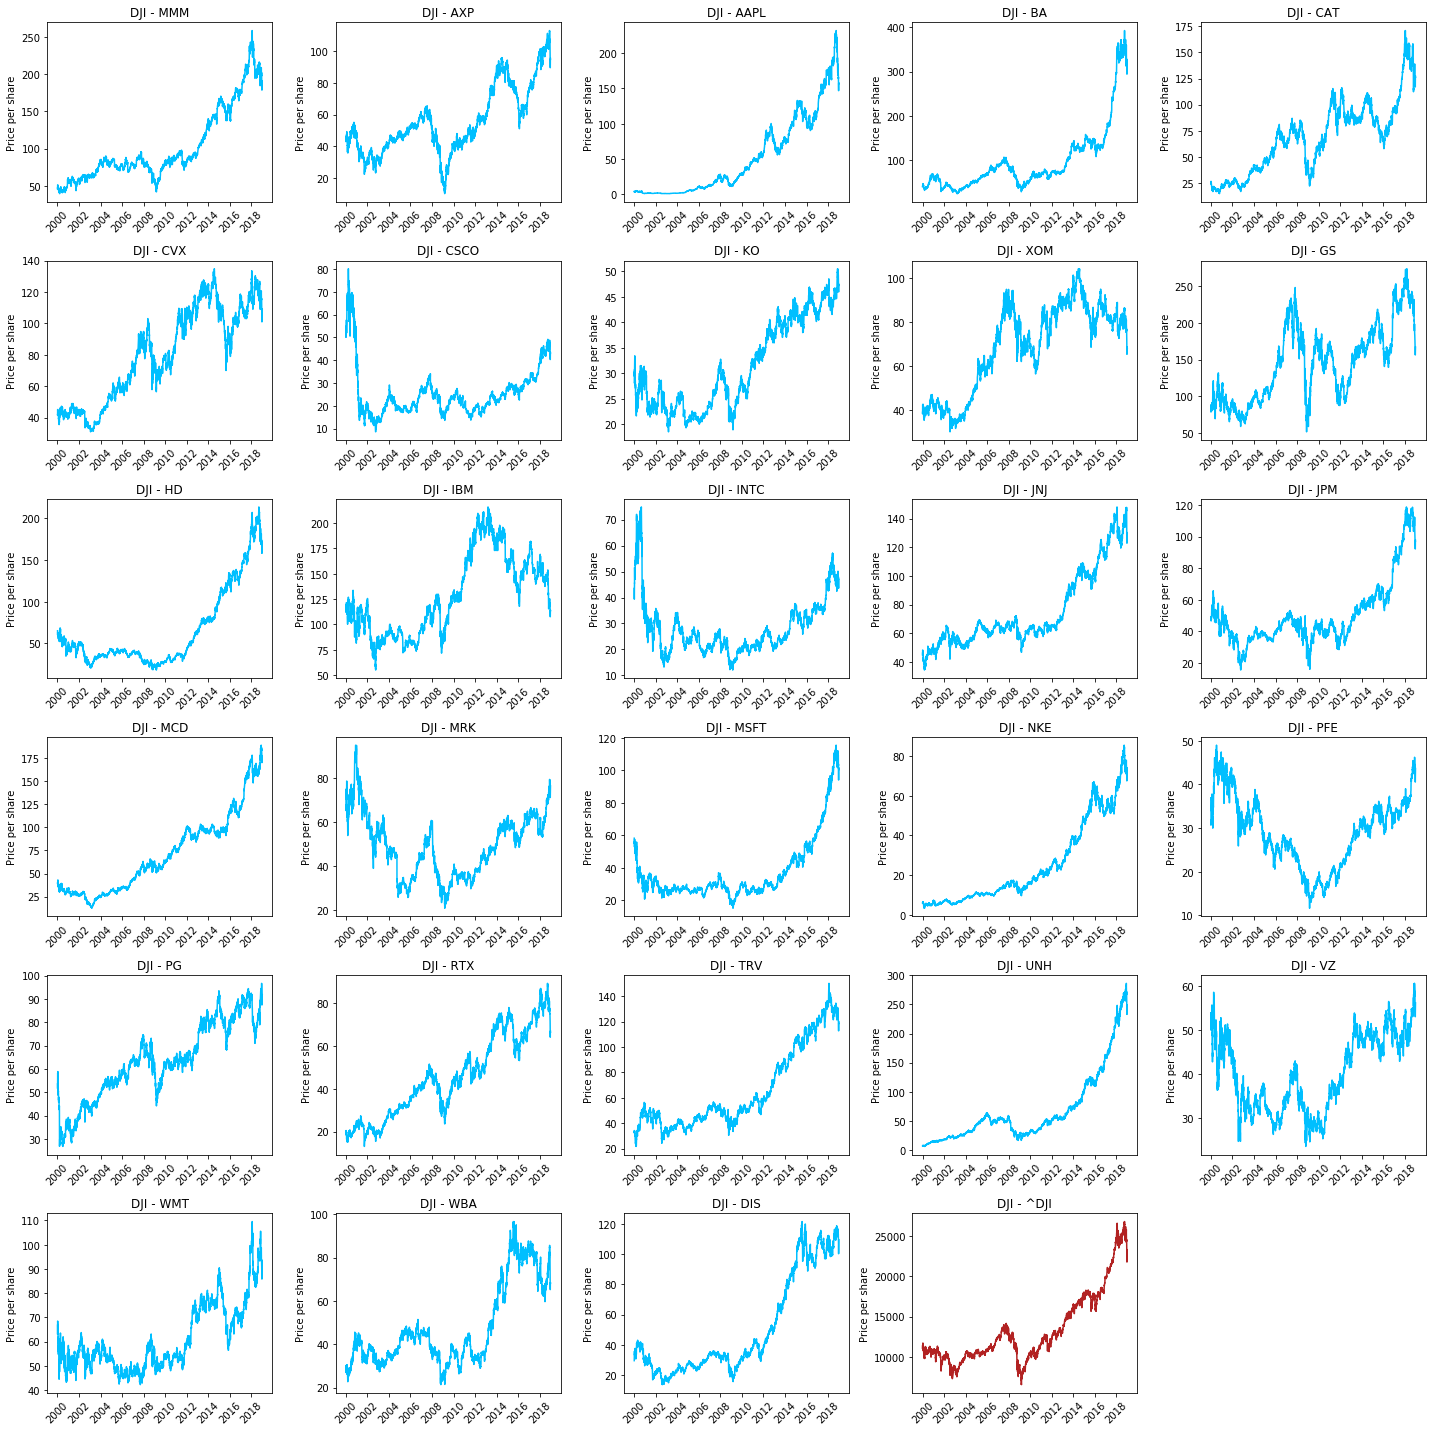

In [370]:
# Make the layout
n_rows = 6
n_cols = 5

plt.figure(figsize = (20,20))
for i,stock in enumerate(df.columns.to_list()):
    # Choose the color
    if stock == '^DJI':
        color = 'firebrick'
    else:
        color = 'deepskyblue'

    # Plot the stock prices
    plt.subplot(n_rows, n_cols, i + 1)
    sns.lineplot(x = df.index, y = df[stock], color = color)

    # Formatting
    plt.title('DJI - {}'.format(stock))
    plt.xlabel('')
    plt.ylabel('Price per share')
    plt.xticks(rotation = 45)

# Formatting
plt.tight_layout()
plt.show()

from where we can expect the series to have a high degree of autorrelation and a high degree of correlations between them and with the DJI index value.

# MODELLING

## Computation of returns

It is a common practice not to analize the price series itself, but its retuns. The returns are computed as the porcentual change in the price series, that is, if the price for an asset $i$ at time $t$ is given by $p_i^{t}$ then its return will be given by

$$ r_i^t = \frac{p_i^t - p_i^{t-1}}{p_i^{t-1}} $$

and it is also common to compute the log-returns, which are simply a logarithmic version of these returns

$$ r_i^{'t} = \log \frac{p_i^t - p_i^{t-1}}{p_i^{t-1}} $$

which provide a smoother representation of the series.

Since some stocks are more volatile than others, it is convenient to work with standardized returns, that is, to substract the mean $\mu_i$ of each return and divide the residual by the return's standard deviation $\sigma_i$, given by

\begin{align*}
    & \mu_i = \frac{1}{T} \sum_{t=1}^T r_i^t \\
    & \sigma_i^2 = \frac{1}{T-1} \sum_{t=1}^T (r_i^t - \mu_i)^2 \ 
\end{align*}

so we get

$$ r_i^t = \frac{r_i^t - \mu_i}{\sigma_i} $$



In [371]:
# Compute the returns
df_returns = df.pct_change().dropna(axis = 0)

# Standarize the returns
df_mean = df_returns.mean(axis = 0)
df_volatility = df_returns.std(axis = 0)
df_stand = (df_returns - df_mean) / df_volatility

And visualizing the returns

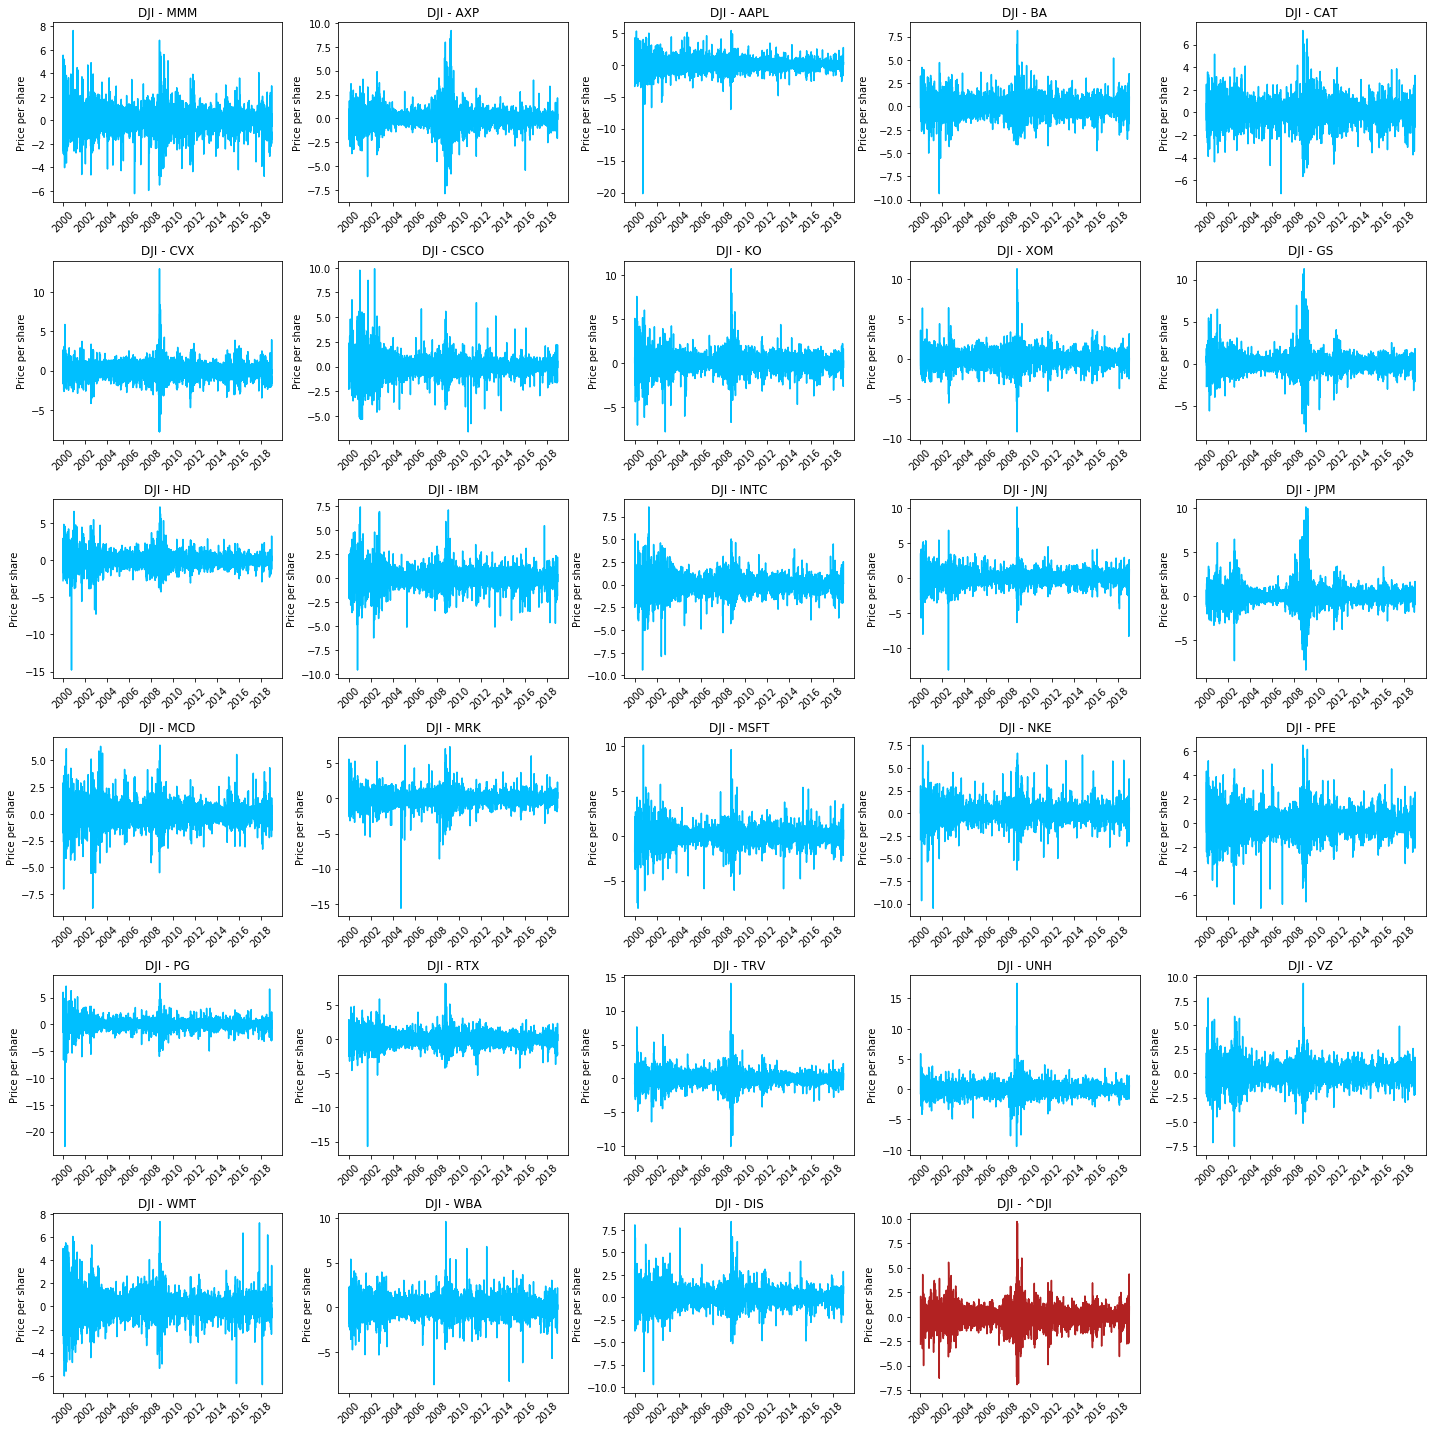

In [372]:
# Make the layout
n_rows = 6
n_cols = 5

plt.figure(figsize = (20,20))
for i,stock in enumerate(df_stand.columns.to_list()):
    # Choose the color
    if stock == '^DJI':
        color = 'firebrick'
    else:
        color = 'deepskyblue'

    # Plot the stock prices
    plt.subplot(n_rows, n_cols, i + 1)
    sns.lineplot(x = df_stand.index, y = df_stand[stock], color = color)

    # Formatting
    plt.title('DJI - {}'.format(stock))
    plt.xlabel('')
    plt.ylabel('Price per share')
    plt.xticks(rotation = 45)

# Formatting
plt.tight_layout()
plt.show()

we can expect that we have eliminated the autocorrelation of each series.

## Creation of train and test sets

Once the data is preprocessed, we have to split it into a training set, to develop our PCA approach to eigen-portfolios, and a test set, to test the performance of this approachto generate an optimal portfolio.

In [373]:
# Choose a data for split the data
date_split = pd.to_datetime('2015-01-01', format = '%Y-%m-%d')

# Create train and test sets
df_stand_train = df_stand[df_returns.index <= date_split].copy()
df_stand_test  = df_stand[df_returns.index >  date_split].copy()

df_train = df_returns[df_returns.index <= date_split].copy()
df_test  = df_returns[df_returns.index >  date_split].copy()

# Split the DJI index from the stocks
X_stand_train = df_stand_train.drop('^DJI', axis = 1)
y_stand_train = df_stand_train[['^DJI']]

X_stand_test = df_stand_test.drop('^DJI', axis = 1)
y_stand_test = df_stand_test[['^DJI']]

X_test = df_test.drop('^DJI', axis = 1)
y_test = df_test[['^DJI']]

## Principal Component Analysis

PCA is defined as an orthogonal linear transformation that transforms the data from the original coordinate system with $\{X_i\}_{i=1}^D$ to a new coordinate system $\{Z_i\}_{i=1}^{D'}$, usually with $D' < D$, with 

$$ Z = X W \Longleftrightarrow X = Z W^T $$

where $W$ is the $D \times D'$ weight matrix of the transformation, which we assume to be orthogonal, that is, satisfying $WW^T = I$. This transformation is done in such a way that the greatest variance of the data comes to lie on the first coordinate $Z_1$ (called the first principal component), the second greatest variance on the second coordinate $Z_2$, and so on. Since the total variance of $X$, make out of $N$ samples, can be computed as

\begin{align*}
    & Var(X) = \frac{1}{N - 1} Tr(X^T X) = Tr(C) = Tr(V \Lambda V^T) = Tr(\Lambda) = \sum_{i=1}^D \lambda_i
\end{align*}

where $C$ is the covariance matrix, which can be diagonalized to the matrix $\Lambda$ using a eigenvalue decomposition. Then, $\{\lambda_i\}_{i=1}^{D}$ denote the eigenvalues of $C$, and $V$ is the matrix whose columns denote the eigenvectors of $C$. So, computing the variance of $Z$, 

\begin{align*} 
    & Var(Z) = \frac{1}{N - 1} Tr(Z^T Z)  = \frac{1}{N - 1} Tr(W^T X^T X W) = Tr(W^T C W) = Tr(W^T V \Lambda V^T W) = Tr(\Lambda) = \sum_{i=1}^D \lambda_i
\end{align*}

we can see that the total variance is conserved in the new projection if we choose $W = V$. This will provide by definition a projection to an orthogonal space, since the vectors of the basis the new space, the eigenvectors contained in $V$, form a orthogonal basis.

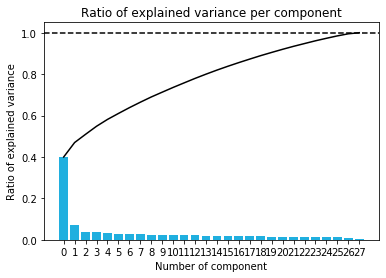

In [374]:
# Train PCA model
pca = PCA()
pca.fit(X_stand_train)

# Plot the variance explained by each principal component
var_explained = pca.explained_variance_ratio_
var_explained_cum = np.cumsum(var_explained)

# Make the plot
sns.barplot(x = np.arange(var_explained.shape[0]), y = var_explained, color = 'deepskyblue')
sns.lineplot(x = np.arange(var_explained.shape[0]), y = var_explained_cum, color = 'black')
plt.axhline(y = 1.0, linestyle = '--',color = 'black')
plt.title('Ratio of explained variance per component')
plt.xlabel('Number of component')
plt.ylabel('Ratio of explained variance')
plt.show()

## Eigen-portfolio construction

As we said, the eigenvectors of the covariance matrix provide the weights to a new space in which the coordinates are orthogonal to each other. In this project, each coordinate represents a stock, so the new coordinates will represent portfolios of stocks, denoted as eigen-portfolios, which combine them in a certain proportion given by these weights. Following \[1\] we define the weight of the stock $i$ in the eigen-portfolio $j$ as:

$$ Q_i^{(j)} = \frac{v_i^{(j)}}{\sigma_i} $$

where $v_i$ represents the $i$-th element of $j$-th eigen vector, that is, the presence of the stock $i$ in the $j$ eigen-portfolio, and $\sigma_i$ represents the volatiliy of the stock $i$.

In [375]:
# Obtain the eigenvectors of the covariance matrix
v = pca.components_.T

# Compute the eigenportfolio weights
eigenportfolios = pd.DataFrame({i : v[:,i] / df_volatility[i] for i in range(v.shape[1]) }, index = X_stand_train.columns.tolist())

eigenportfolios = eigenportfolios/ eigenportfolios.sum()

Each portfolio will describe some proportion of the variance of the market. Specifically, since the first eigen-porfolio will explain the majority of this variance, we can expect it to reproduce the evolution of the market, which in our case is described by the evolution of the DJI index. Taking a look to the firsts eigen-porfolio

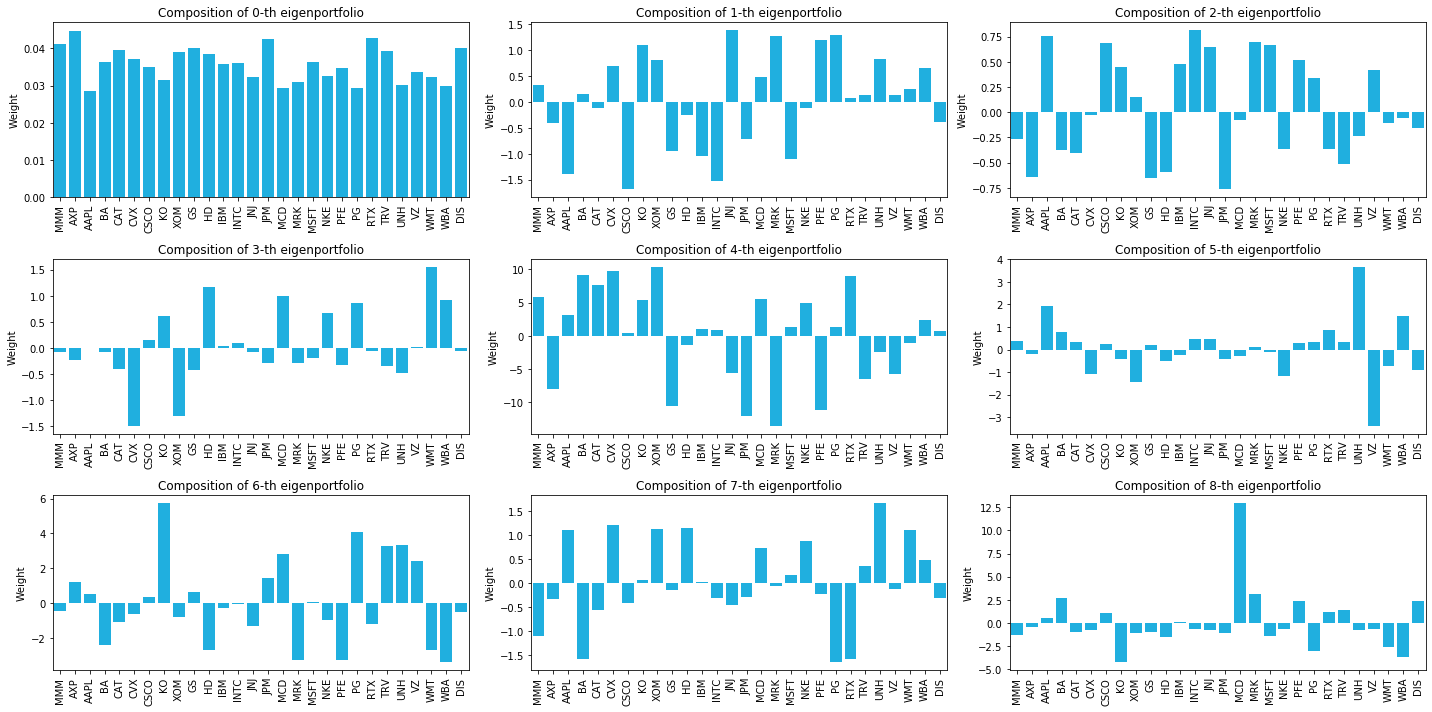

In [376]:
# Make the layout
n_rows = 3
n_cols = 3

plt.figure(figsize=(20,10))
for i in range(n_rows * n_cols):
    # Make the plot
    plt.subplot(n_rows, n_cols, i + 1)
    sns.barplot(x = eigenportfolios.index, y = eigenportfolios[i], color = 'deepskyblue')

    # Formatting
    plt.title('Composition of {}-th eigenportfolio'.format(i))
    plt.xlabel('')
    plt.ylabel('Weight')
    plt.xticks(rotation = 90)

# Formatting
plt.tight_layout()
plt.show()

## Computation of Sharpe ratio

In finance, the Sharpe ratio measures the performance of an investment compared to a risk-free asset, after adjusting for its risk. It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment, that is, its volatility. It represents the additional amount of return that an investor receives per unit of increase in risk, that is, how well the return of an asset compensates the investor for the risk taken. It was named after William F. Sharpe, who developed it in 1966 \[2\].

- find portfolio (an index into sharpe_metric) that has the highest sharpe ratio

In [381]:
def sharpe_ratio(ts_returns, periods_per_year = 252):
    """
    Calculates the Sharpe ratio of a time-series of prices.
                    
    Args:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """
    
    n_years = ts_returns.shape[0] / periods_per_year

    # Compute the annualized returns
    annualized_returns = np.prod(1 + ts_returns)

    # Compute the volatility
    annualized_volatility = ts_returns.std()

    # Compute the Sharpe ratio
    annualized_sharpe = (annualized_returns - 1) / annualized_volatility

    return annualized_sharpe

In [382]:
# Initalize a empty list
sharpe_ratios = []

# Copute Sharpe ratio for all portfolios
for i in range(eigenportfolios.shape[1]):
    # Compute the portfolio returns and cummulative returns
    portfolio_returns = pd.Series(np.dot(X_test, eigenportfolios[i]), index=X_test.index)

    # Compute the Sharpe ratio
    sharpe = sharpe_ratio(portfolio_returns)
    sharpe_ratios.append(sharpe)

best_portfolios = np.argsort(sharpe_ratios)[::-1][1:]

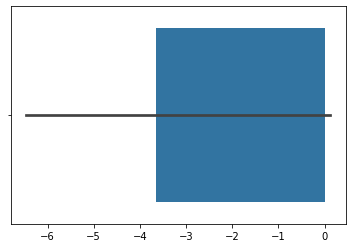

In [385]:
sns.barplot(x = eigenportfolios.index, y = sharpe_ratios, color = 'deepskyblue')

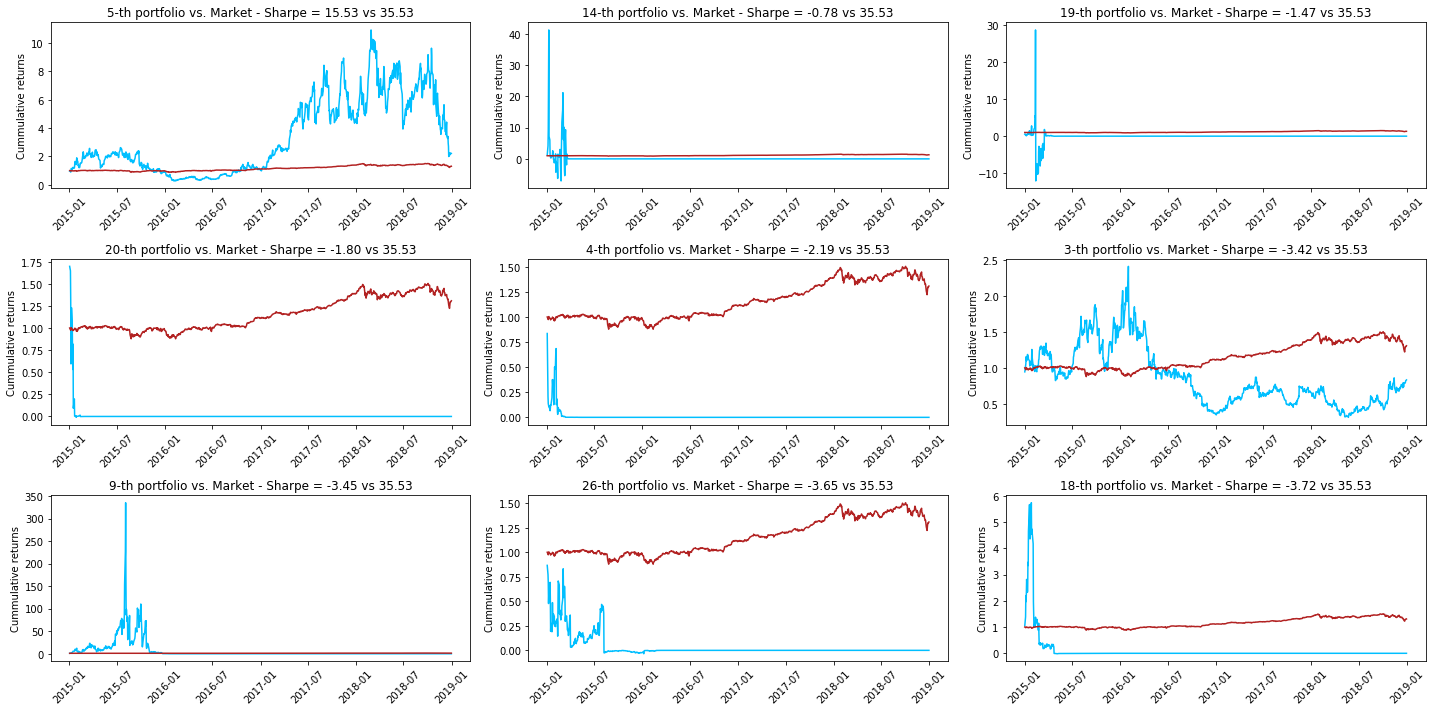

In [384]:
# Make the layout
n_rows = 3
n_cols = 3

plt.figure(figsize=(20,10))
for i in range(n_rows * n_cols):
    # Compute the portfolio returns and cummulative returns
    portfolio_returns = pd.Series(np.dot(X_test, eigenportfolios[best_portfolios[i]]), index=X_test.index)
    portfolio_cum_returns = np.cumprod(portfolio_returns + 1)
    
    # Compute the market returns and cummulative returns
    market_returns = np.squeeze(y_test)
    market_cum_returns = np.cumprod(market_returns + 1)

    # Compute the Sharpe ratio
    sharpe = sharpe_ratio(portfolio_returns)
    sharpe2 = sharpe_ratio(market_returns)

    # Make the plot
    plt.subplot(n_rows, n_cols, i + 1)
    sns.lineplot(x = X_test.index, y = portfolio_cum_returns, color = 'deepskyblue')
    sns.lineplot(x = X_test.index, y = market_cum_returns, color = 'firebrick')
    plt.title('{}-th portfolio vs. Market - Sharpe = {:.2f} vs {:.2f}'.format(best_portfolios[i], sharpe, sharpe2))
    plt.xlabel('')
    plt.ylabel('Cummulative returns')
    plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()